<a href="https://colab.research.google.com/github/Samjacob007/Time-Series/blob/main/Time_Series_Modelling_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libaries

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from itertools import product
from tensorflow.keras.layers import Input


In [74]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data


In [75]:
# Adjust the paths below according to your actual file location in Google Drive
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv', parse_dates=['date'], index_col='date')
amzn_df = pd.read_csv('/content/drive/MyDrive/AMZN.csv', parse_dates=['Date'], index_col='Date')

# Verify the data is loaded correctly
print(jj_df.head())
print(amzn_df.head())

            data
date            
1960-01-01  0.71
1960-04-01  0.63
1960-07-02  0.85
1960-10-01  0.44
1961-01-01  0.61
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-02-20  72.324501  74.438499  72.324501  73.417503  73.417503  129984000
2018-02-21  74.250000  75.174500  73.945999  74.146004  74.146004  126088000
2018-02-22  74.767998  75.126999  73.788002  74.266998  74.266998   97162000
2018-02-23  74.766998  75.000000  74.324997  75.000000  75.000000   88362000
2018-02-26  75.459999  76.141998  75.349998  76.097504  76.097504   99100000


#Initial Plots


## Johnson&Johnson

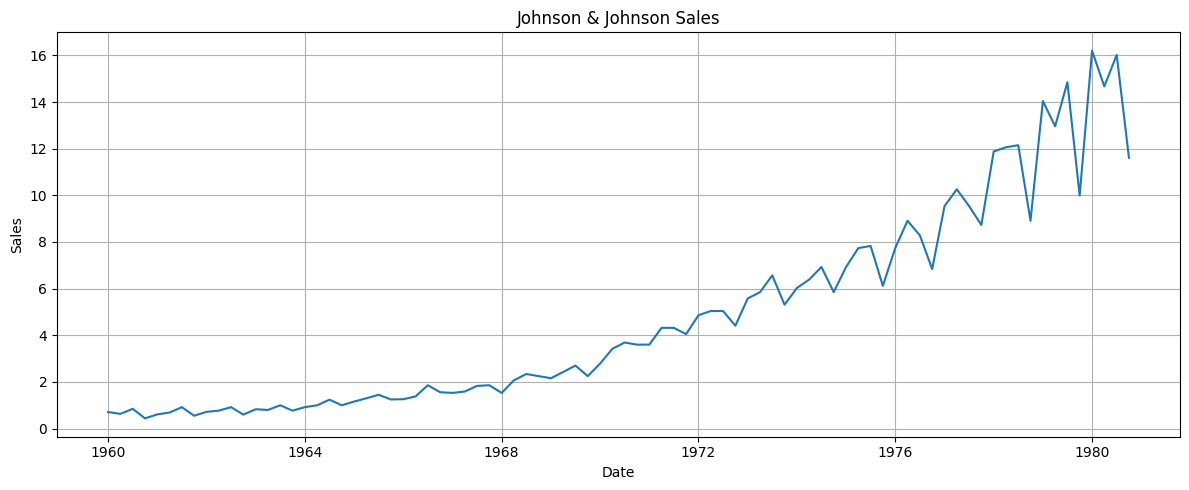

In [76]:
# Plotting Johnson & Johnson Sales Data
plt.figure(figsize=(12, 5))
plt.plot(jj_df.index, jj_df.values)
plt.title("Johnson & Johnson Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()



## Amazon data

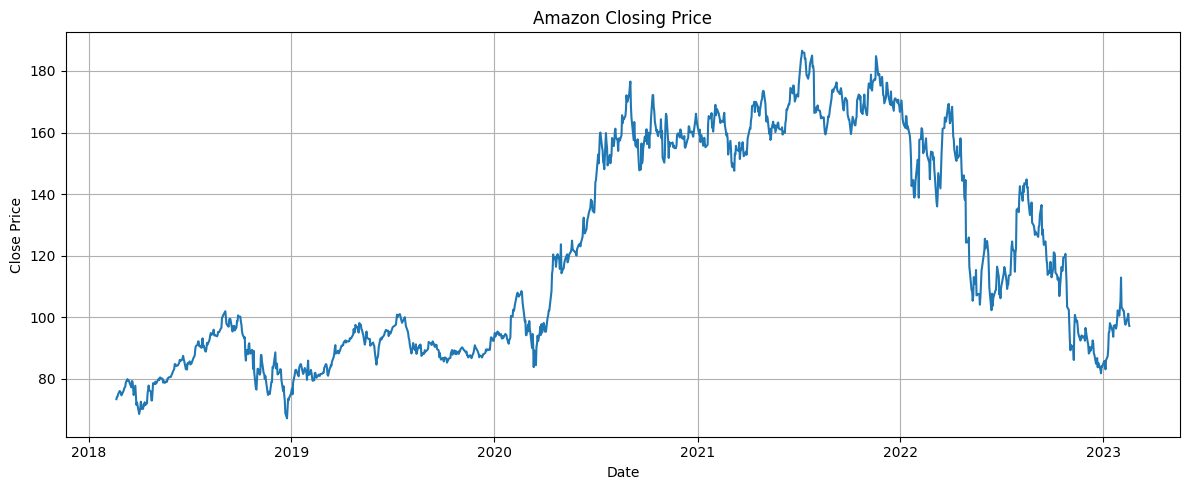

In [77]:
# Plotting Amazon Closing Price Data
plt.figure(figsize=(12, 5))
plt.plot(amzn_df.index, amzn_df['Close'])
plt.title("Amazon Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

#ACF/PACF Before Transformation

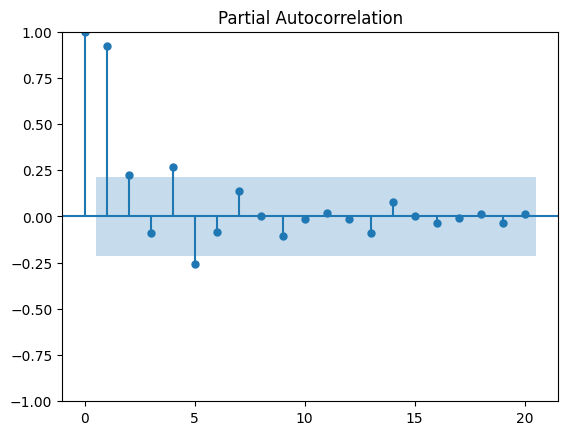

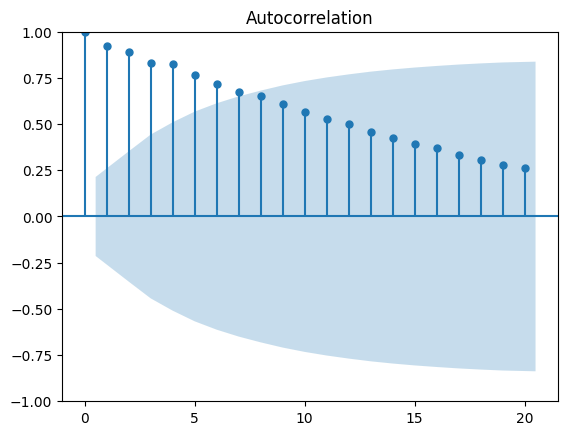

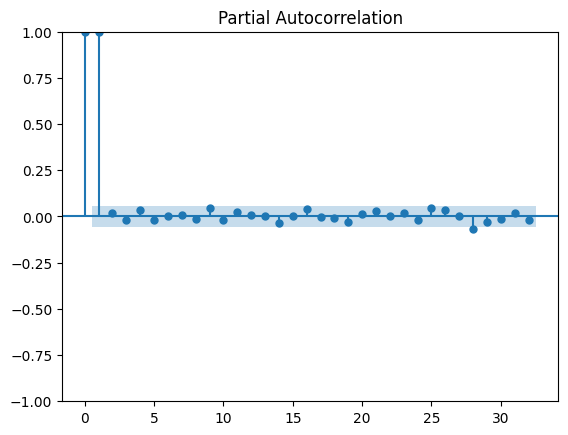

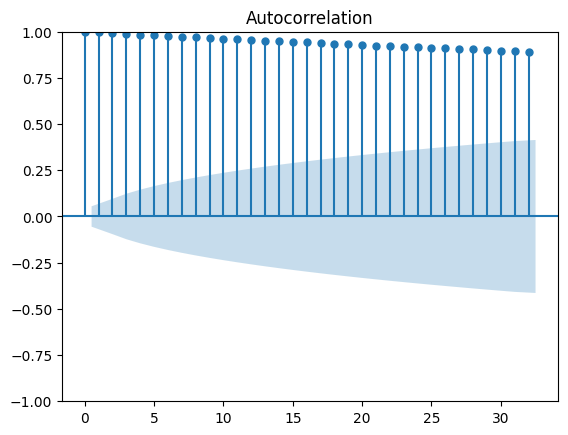

In [78]:
plot_pacf(jj_df['data']);
plot_acf(jj_df['data']);
plt.show()
plot_pacf(amzn_df['Close'])
plot_acf(amzn_df['Close'])
plt.show()

#(ADF) Test for Stationarity

In [79]:


def run_adf_test(series, series_name):

    result = adfuller(series)
    print(f"ADF Test for {series_name}")
    print("-" * (17 + len(series_name)))
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"   {key} : {value:.4f}")
    print("\n")

# Run ADF test on Johnson & Johnson sales data
run_adf_test(jj_df['data'], "Johnson & Johnson Sales")

# Run ADF test on Amazon closing price
run_adf_test(amzn_df['Close'], "Amazon Closing Price")


ADF Test for Johnson & Johnson Sales
----------------------------------------
ADF Statistic : 2.7420
p-value       : 1.0000
Critical Values:
   1% : -3.5246
   5% : -2.9026
   10% : -2.5887


ADF Test for Amazon Closing Price
-------------------------------------
ADF Statistic : -1.6578
p-value       : 0.4530
Critical Values:
   1% : -3.4356
   5% : -2.8638
   10% : -2.5680




#Transforms for Stationarity: Log + First Difference

In [80]:
def transform_series(df, col, new_log_col, new_diff_col, label):

    df[new_log_col] = np.log(df[col])
    df[new_diff_col] = df[new_log_col].diff()
    print(f"\n🔹 {label} - Transformed Data (First 10 rows):")
    print(df[[col, new_log_col, new_diff_col]].head(10))

# Transform Johnson & Johnson data
transform_series(jj_df, 'data', 'data_log', 'data_tr_1', 'Johnson & Johnson')

# Transform Amazon closing price data
transform_series(amzn_df, 'Close', 'Close_log', 'Close_tr_1', 'Amazon')



🔹 Johnson & Johnson - Transformed Data (First 10 rows):
            data  data_log  data_tr_1
date                                 
1960-01-01  0.71 -0.342490        NaN
1960-04-01  0.63 -0.462035  -0.119545
1960-07-02  0.85 -0.162519   0.299517
1960-10-01  0.44 -0.820981  -0.658462
1961-01-01  0.61 -0.494296   0.326684
1961-04-02  0.69 -0.371064   0.123233
1961-07-02  0.92 -0.083382   0.287682
1961-10-01  0.55 -0.597837  -0.514455
1962-01-01  0.72 -0.328504   0.269333
1962-04-02  0.77 -0.261365   0.067139

🔹 Amazon - Transformed Data (First 10 rows):
                Close  Close_log  Close_tr_1
Date                                        
2018-02-20  73.417503   4.296162         NaN
2018-02-21  74.146004   4.306036    0.009874
2018-02-22  74.266998   4.307667    0.001631
2018-02-23  75.000000   4.317488    0.009821
2018-02-26  76.097504   4.332015    0.014527
2018-02-27  75.598999   4.325443   -0.006572
2018-02-28  75.622498   4.325754    0.000311
2018-03-01  74.672501   4.313112   -

# Visualization of Log-Differenced Data

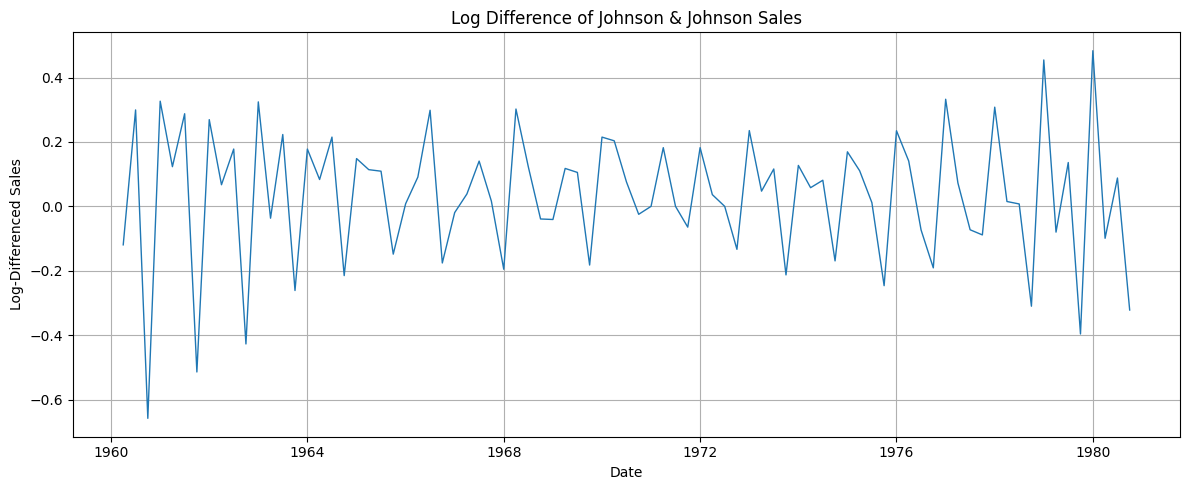

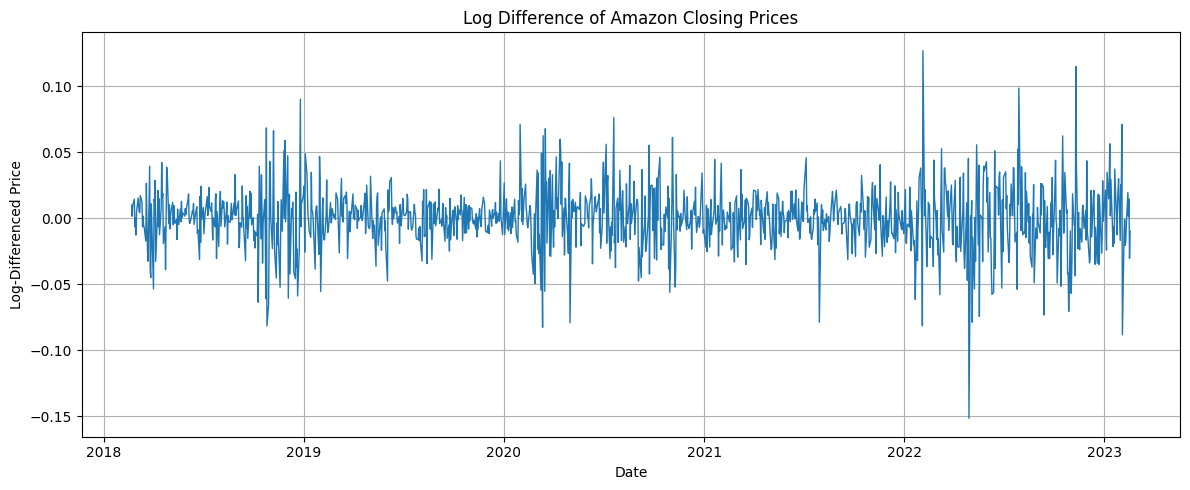

In [81]:
def plot_log_difference(series, title, ylabel):
    """Plot a log-differenced time series."""
    plt.figure(figsize=(12, 5))
    plt.plot(series, linewidth=1)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for Johnson & Johnson
plot_log_difference(jj_df['data_tr_1'],
                    "Log Difference of Johnson & Johnson Sales",
                    "Log-Differenced Sales")

# Plot for Amazon
plot_log_difference(amzn_df['Close_tr_1'],
                    "Log Difference of Amazon Closing Prices",
                    "Log-Differenced Price")

# Re-Test Adf

In [82]:
def run_adf_test(series, label):
    """Runs ADF test on a time series and prints formatted output."""
    result = adfuller(series.dropna())  # drop NaN instead of slicing
    print(f"\n🔹 ADF Test - {label}")
    print("-" * (14 + len(label)))
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key} : {value:.4f}")

# ADF test on log-differenced Johnson & Johnson data
run_adf_test(jj_df['data_tr_1'], "Johnson & Johnson (Log-Diff)")

# ADF test on log-differenced Amazon data
run_adf_test(amzn_df['Close_tr_1'], "Amazon (Log-Diff)")


🔹 ADF Test - Johnson & Johnson (Log-Diff)
------------------------------------------
ADF Statistic : -4.3170
p-value       : 0.0004
Critical Values:
   1% : -3.5183
   5% : -2.8999
   10% : -2.5872

🔹 ADF Test - Amazon (Log-Diff)
-------------------------------
ADF Statistic : -36.6398
p-value       : 0.0000
Critical Values:
   1% : -3.4356
   5% : -2.8638
   10% : -2.5680


#Define an ARIMA mode

In [83]:

def fit_arima_model(series, order, label):

    print(f"\n🔹 ARIMA Model Summary - {label} (Order={order})")
    print("-" * (32 + len(label)))
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

# Fit ARIMA(3,1,3) for Johnson & Johnson
jj_model_fit = fit_arima_model(jj_df['data'], order=(3, 1, 3), label="Johnson & Johnson")

# Fit ARIMA(3,1,3) for Amazon
amzn_model_fit = fit_arima_model(amzn_df['Close'], order=(3, 1, 3), label="Amazon")


🔹 ARIMA Model Summary - Johnson & Johnson (Order=(3, 1, 3))
-------------------------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -76.286
Date:                Fri, 11 Apr 2025   AIC                            166.572
Time:                        05:18:15   BIC                            183.504
Sample:                             0   HQIC                           173.374
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0311      0.036    -28.924      0.000      -1.101      -0.961
ar.L2         -1.0273      0.043    -23.892      0.000      -1.112      -0.943
ar.L3         -0.9768      0.030    -32.190      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3055.652
Date:                Fri, 11 Apr 2025   AIC                           6125.305
Time:                        05:18:16   BIC                           6161.266
Sample:                             0   HQIC                          6138.820
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7321      0.062    -11.836      0.000      -0.853      -0.611
ar.L2          0.6699      0.102      6.538      0.000       0.469       0.871
ar.L3          0.9210      0.060     15.446      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#optimize Arima


In [84]:
def optimize_ARIMA(endog, order_list, verbose=False):


    results = []

    for order in tqdm(order_list, desc="Fitting ARIMA models"):
        try:
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
            aic = model_fit.aic
            results.append([order, aic])
            if verbose:
                print(f"Fitted ARIMA{order} - AIC: {aic:.2f}")
        except Exception as e:
            if verbose:
                print(f"Failed ARIMA{order}: {e}")
            continue

    # Convert results to DataFrame
    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC'])
    result_df = result_df.sort_values('AIC').reset_index(drop=True)

    return result_df

In [85]:

p_range = range(0, 8)
q_range = range(0, 8)
d = 1

# Create list of (p, d, q) tuples
order_list = [(p, d, q) for p, q in product(p_range, q_range)]

# Display first 10 combinations
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [86]:
def optimize_ARIMA(endog, order_list, verbose=False):

    results = []

    for order in tqdm(order_list, desc="Optimizing ARIMA models"):
        try:
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
            aic = model_fit.aic
            results.append([order, aic])
        except Exception as e:
            if verbose:
                print(f"Failed to fit ARIMA{order}: {e}")
            continue

    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC').reset_index(drop=True)

    return result_df

In [87]:

best_order = (6, 1, 3)
best_model = ARIMA(jj_df['data'], order=best_order)
best_model_fit = best_model.fit()

# Display model summary
print(f"🔹 ARIMA{best_order} Model Summary - Johnson & Johnson:\n")
print(best_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

🔹 ARIMA(6, 1, 3) Model Summary - Johnson & Johnson:

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.649
Date:                Fri, 11 Apr 2025   AIC                            115.297
Time:                        05:18:23   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      -1.225
ar.L2         -0.7728      0.148     -5.235      0.000      -1.062      -0.484

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#Model Diagnostics

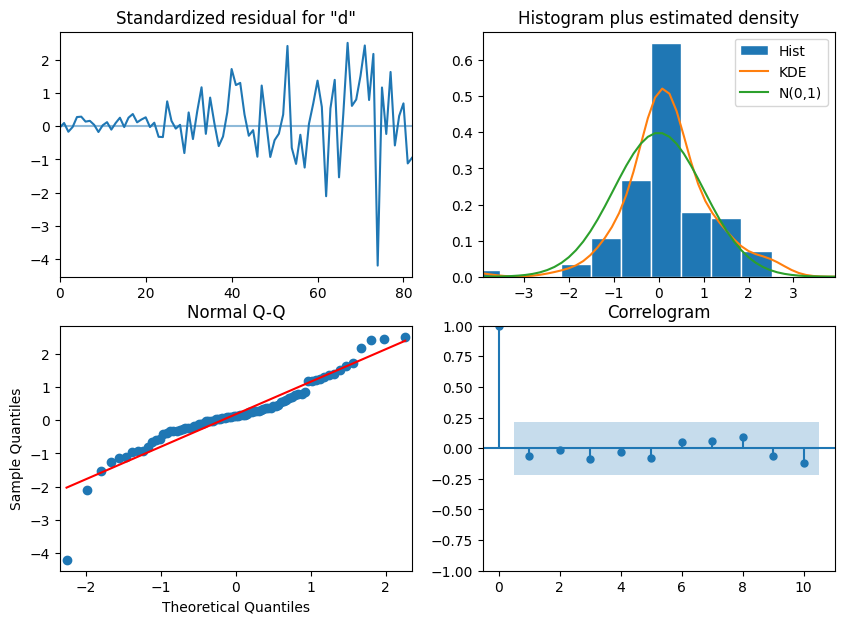

In [88]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

#Residuals

In [89]:

test_data = jj_df['data']

# Get prediction start and end dates
pred_start = test_data.index[0]
pred_end = test_data.index[-1]

# Generate in-sample predictions using the fitted ARIMA model
predictions = best_model_fit.predict(start=pred_start, end=pred_end)

# Ensure predictions and test_data are aligned
predictions = predictions[:len(test_data)]

# Calculate residuals
residuals = test_data - predictions

# Display first few residuals
print("🔹 Sample Residuals (Johnson & Johnson):")
print(residuals.head())

🔹 Sample Residuals (Johnson & Johnson):
date
1960-01-01    0.710000
1960-04-01   -0.079998
1960-07-02    0.172923
1960-10-01   -0.287089
1961-01-01   -0.033088
dtype: float64


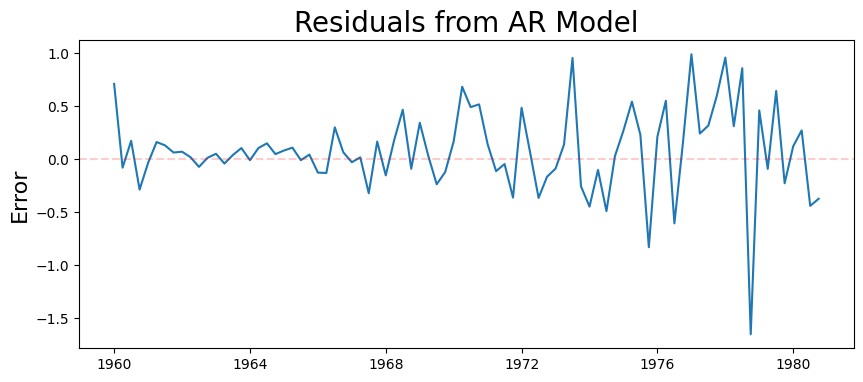

In [90]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [91]:
# root mean square of the residuals

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.3999081195935732


# j&j prediction

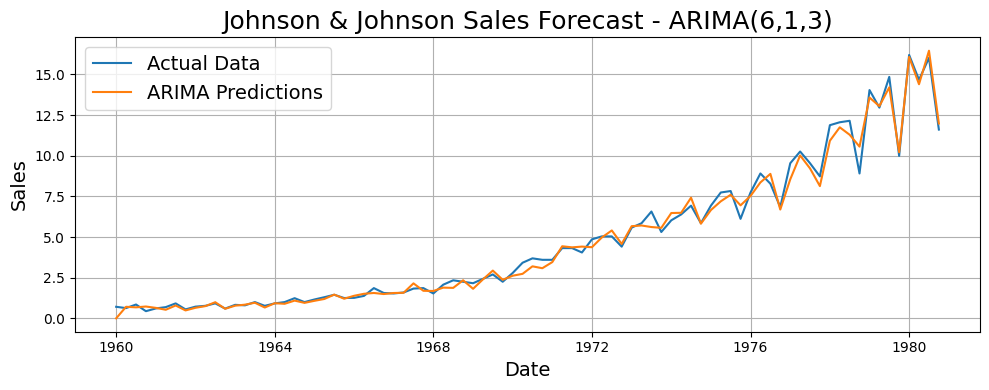

In [92]:
# Plot the model prediction against the actual data
plt.figure(figsize=(10, 4))

plt.plot(test_data, label='Actual Data')
plt.plot(predictions, label='ARIMA Predictions')

plt.legend(fontsize=14)
plt.title('Johnson & Johnson Sales Forecast - ARIMA(6,1,3)', fontsize=18)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [93]:
import numpy as np

def forecast_accuracy(forecast, actual):
    # Convert inputs to 1D NumPy arrays
    forecast = np.array(forecast).flatten()
    actual = np.array(actual).flatten()

    # Accuracy metrics
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))       # MAPE
    me = np.mean(forecast - actual)                                # ME
    mae = np.mean(np.abs(forecast - actual))                       # MAE
    mpe = np.mean((forecast - actual)/actual)                      # MPE
    rmse = np.mean((forecast - actual)**2)**0.5                    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                      # Correlation
    mins = np.amin(np.vstack([forecast, actual]), axis=0)
    maxs = np.amax(np.vstack([forecast, actual]), axis=0)
    minmax = 1 - np.mean(mins / maxs)                              # MinMax

    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'corr': corr,
        'minmax': minmax
    }


In [94]:
forecast_accuracy(predictions, test_data)

{'mape': np.float64(0.08945519428653988),
 'me': np.float64(-0.07906178477112123),
 'mae': np.float64(0.2789680779228482),
 'mpe': np.float64(-0.027613316081548874),
 'rmse': np.float64(0.3999081195935732),
 'corr': np.float64(0.9958097298551797),
 'minmax': np.float64(0.08437238270774561)}

#Forecast J&J

In [95]:
def plot_arima_forecast_jj(model_fit, original_series, n_forecast=24,
                            title='Johnson & Johnson Sales Forecast', forecast_color='orange'):

    # Generate forecast
    forecast_result = model_fit.get_forecast(steps=n_forecast)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()

    # Create forecast date index
    last_date = original_series.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                   periods=n_forecast, freq='M')

    # Plot observed and forecast
    plt.figure(figsize=(12, 6))
    plt.plot(original_series.index, original_series, label='Observed', color='blue')
    plt.plot(forecast_index, forecast_mean, label='Forecast', color=forecast_color, linestyle='--')
    plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                     color=forecast_color, alpha=0.3, label='95% Confidence Interval')

    plt.title(title, fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Sales', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast_mean, forecast_ci

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-95-46395595903e>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1),


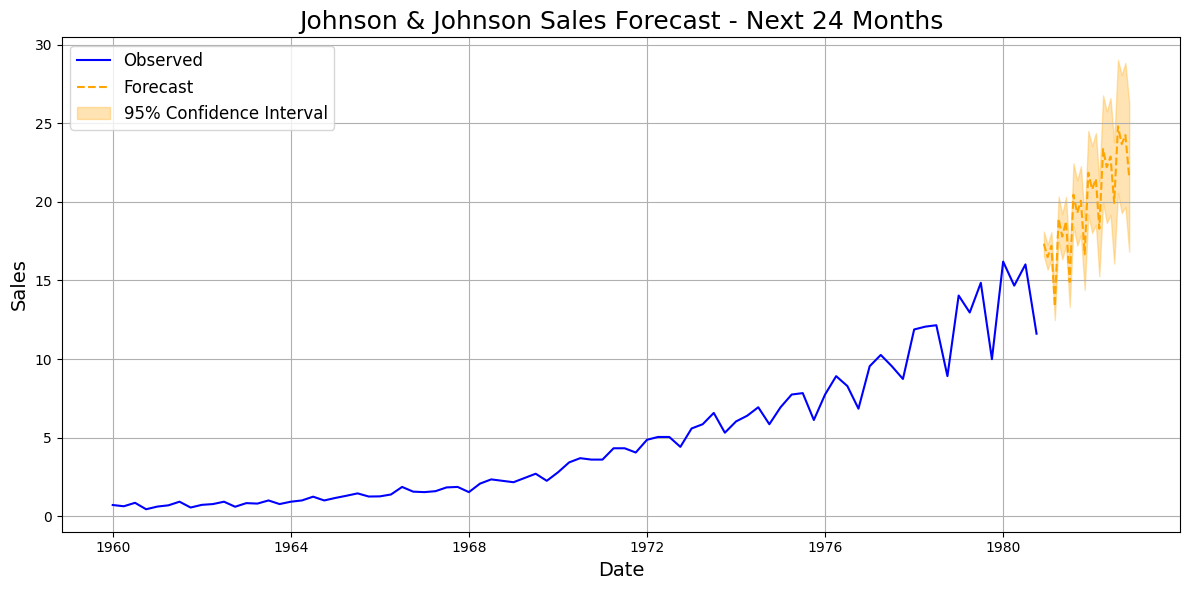

In [96]:
# Johnson & Johnson ARIMA forecast (24 months)
forecast_mean_jj, forecast_ci_jj = plot_arima_forecast_jj(
    best_model_fit,
    jj_df['data'],
    n_forecast=24,
    title='Johnson & Johnson Sales Forecast - Next 24 Months'
)

In [97]:
# use get_forecast() for this

# make the predictions for 24 steps ahead
predictions_int = best_model_fit.get_forecast(steps=26)
predictions_int.predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_mean
84,17.336626
85,16.481965
86,17.203514
87,13.344421
88,18.924689
89,17.790273
90,18.762096
91,14.903689
92,20.454214
93,19.287892


In [98]:
# get a better view
predictions_int.conf_int()

,lower data,upper data
84,16.565851,18.107401
85,15.687898,17.276032
86,16.341313,18.065716
87,12.481034,14.207809
88,17.509056,20.340322
89,16.346398,19.234148
90,17.212370,20.311821
91,13.320640,16.486737
92,18.460356,22.448071
93,17.212097,21.363686


In [99]:
# Combine predicted mean and confidence intervals into a single DataFrame
conf_df = pd.concat([
    predictions_int.predicted_mean.rename('Predicted_Mean'),
    predictions_int.conf_int().rename(columns={
        predictions_int.conf_int().columns[0]: 'Lower_CI',
        predictions_int.conf_int().columns[1]: 'Upper_CI'
    })
], axis=1)

# Preview the result
conf_df.head()

,Predicted_Mean,Lower_CI,Upper_CI
84,17.336626,16.565851,18.107401
85,16.481965,15.687898,17.276032
86,17.203514,16.341313,18.065716
87,13.344421,12.481034,14.207809
88,18.924689,17.509056,20.340322


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-100-1fb4b1263886>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=jj_df.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='M')
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


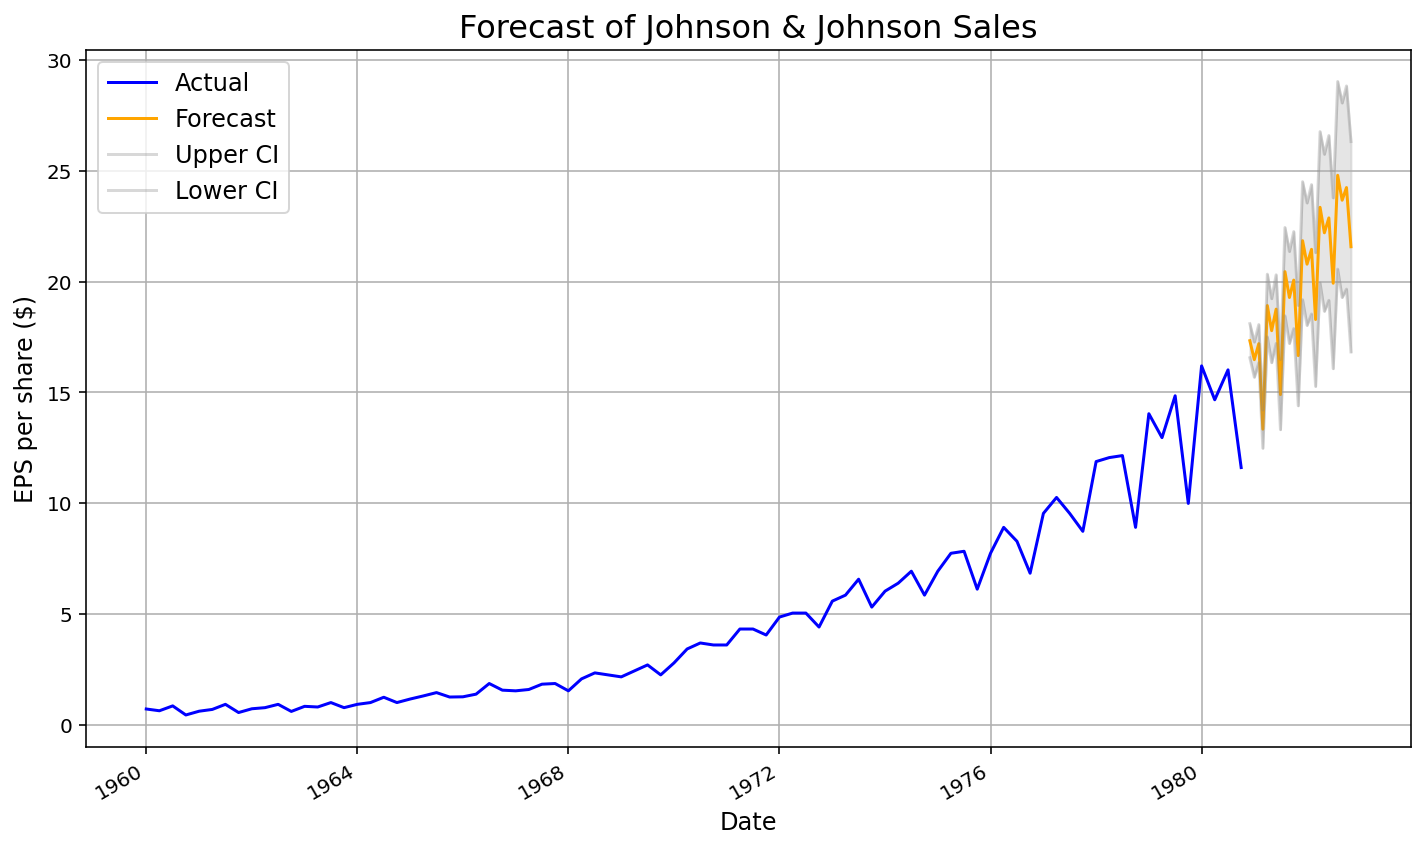

In [100]:
# Generate 24-month forecast
n_forecast = 24
forecast_obj = best_model_fit.get_forecast(steps=n_forecast)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Create a date range for the forecast
forecast_index = pd.date_range(start=jj_df.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='M')

# Create confidence interval DataFrame
conf_df = pd.DataFrame({
    'Predictions': forecast_mean.values,
    'Lower CI': forecast_ci.iloc[:, 0].values,
    'Upper CI': forecast_ci.iloc[:, 1].values
}, index=forecast_index)

# Plot model fit and forecast with confidence interval
fig, ax = plt.subplots(figsize=(10, 6), dpi=144)
ax.plot(jj_df['data'], 'b', label='Actual')

# Plot predictions and confidence intervals
conf_df['Predictions'].plot(ax=ax, color='orange', label='Forecast')
conf_df['Upper CI'].plot(ax=ax, color='grey', alpha=0.3, label='Upper CI')
conf_df['Lower CI'].plot(ax=ax, color='grey', alpha=0.3, label='Lower CI')

# Fill between upper and lower CI
ax.fill_between(conf_df.index, conf_df['Lower CI'], conf_df['Upper CI'], color='grey', alpha=0.2)

# Final plot settings
ax.set_title('Forecast of Johnson & Johnson Sales', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('EPS per share ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [101]:

# fit ARIMA(3,1,3) model for Amazon
amzn_model = ARIMA(amzn_df['Close'], order=(3, 1, 3))
amzn_model_fit = amzn_model.fit()

# Display model summary
print("🔹 ARIMA(3,1,3) Model Summary - Amazon Closing Prices:\n")
print(amzn_model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

🔹 ARIMA(3,1,3) Model Summary - Amazon Closing Prices:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3055.652
Date:                Fri, 11 Apr 2025   AIC                           6125.305
Time:                        05:19:00   BIC                           6161.266
Sample:                             0   HQIC                          6138.820
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7321      0.062    -11.836      0.000      -0.853      -0.611
ar.L2          0.6699      0.102      6.538      0.000       0.469       0.8

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [102]:
# Run ARIMA model optimization on Amazon closing prices
amzn_result_df = optimize_ARIMA(amzn_df['Close'], order_list)

# Display top 5 models (lowest AIC first)
print("🔹 Top ARIMA Models for Amazon (Sorted by AIC):")
amzn_result_df.head()


Optimizing ARIMA models:   0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be 

🔹 Top ARIMA Models for Amazon (Sorted by AIC):


,"(p, d, q)",AIC
0,"(2, 1, 2)",6122.315476
1,"(3, 1, 2)",6124.039832
2,"(2, 1, 3)",6124.044468
3,"(3, 1, 3)",6125.304890
4,"(4, 1, 2)",6125.951759


In [103]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the best ARIMA model based on AIC
amzn_best_model = ARIMA(amzn_df['Close'], order=(2, 1, 2))
amzn_best_model_fit = amzn_best_model.fit()

# Display model summary
print("🔹 ARIMA(2,1,2) Model Summary - Amazon Closing Prices:\n")
print(amzn_best_model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


🔹 ARIMA(2,1,2) Model Summary - Amazon Closing Prices:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3056.158
Date:                Fri, 11 Apr 2025   AIC                           6122.315
Time:                        05:20:39   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.813      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.728      0.000      -0.989      -0.9

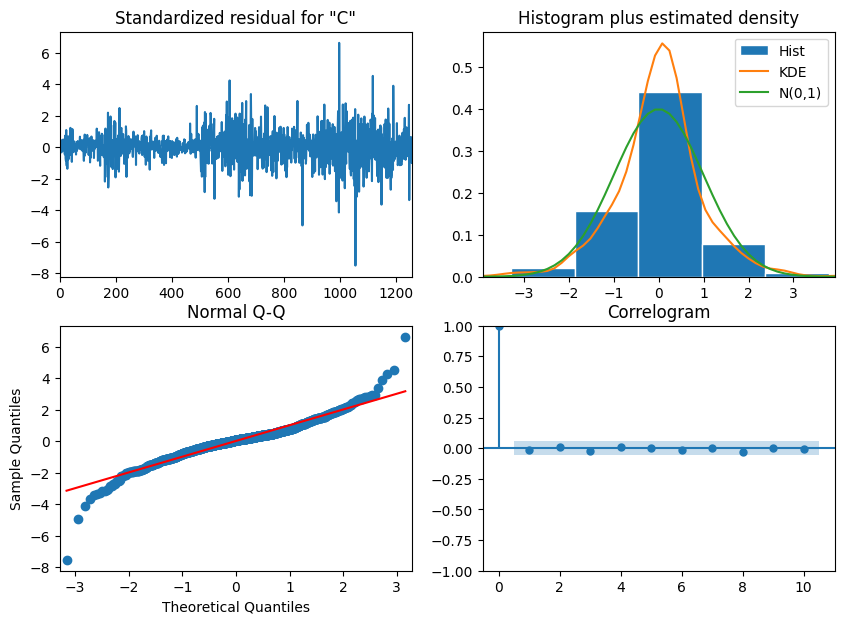

In [104]:

amzn_best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [105]:
#  the actual test data
amzn_test_data = amzn_df['Close']

# prediction range based on the actual data index
pred_start_date = amzn_test_data.index[0]
pred_end_date = amzn_test_data.index[-1]

# Generate in-sample predictions using the ARIMA model
amzn_predictions = amzn_best_model_fit.predict(start=pred_start_date, end=pred_end_date)

# Align predictions length if needed (optional safety step)
amzn_predictions = amzn_predictions[:len(amzn_test_data)]

# Calculate residuals
amzn_residuals = amzn_test_data - amzn_predictions

# Preview residuals
print("🔹 Sample Residuals (Amazon):")
print(amzn_residuals.head())

🔹 Sample Residuals (Amazon):
Date
2018-02-20    73.417503
2018-02-21     0.728506
2018-02-22     0.127194
2018-02-23     0.719471
2018-02-26     1.119403
dtype: float64


In [106]:

amzn_df.index


DatetimeIndex(['2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-05',
               ...
               '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15',
               '2023-02-16', '2023-02-17'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

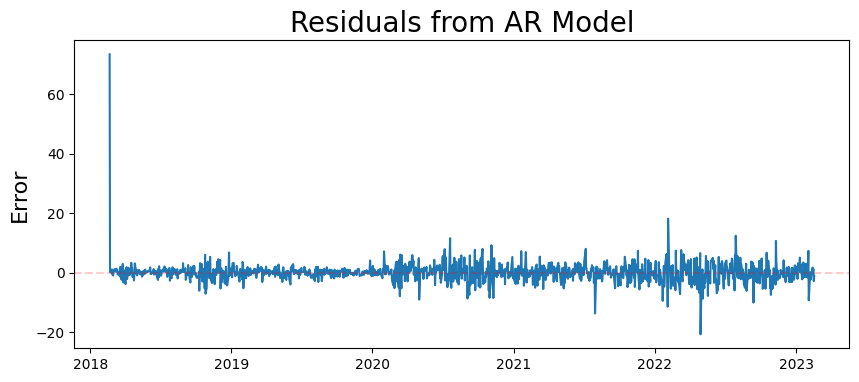

In [107]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(amzn_residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [108]:
# Assess the root mean square of the residuals

print('Root Mean Squared Error:', np.sqrt(np.mean(amzn_residuals**2)))

Root Mean Squared Error: 3.4377142885862564


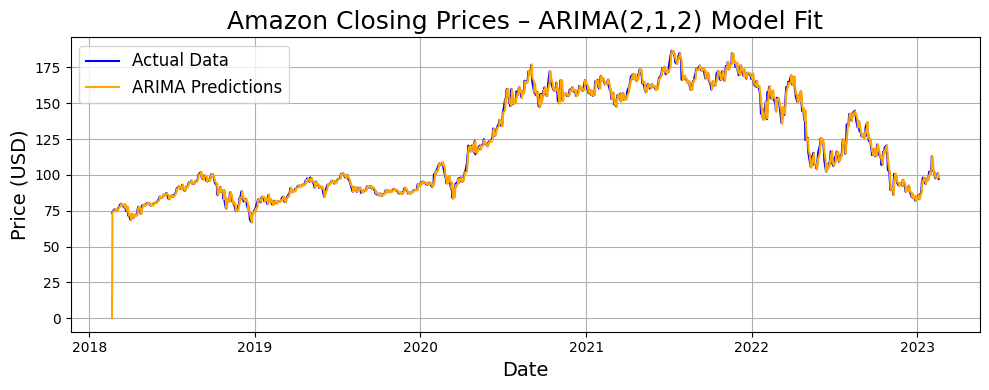

In [109]:
# Plot actual vs predicted closing prices
plt.figure(figsize=(10, 4))

plt.plot(amzn_test_data, color='blue', label='Actual Data')
plt.plot(amzn_predictions, color='orange', label='ARIMA Predictions')

plt.title('Amazon Closing Prices – ARIMA(2,1,2) Model Fit', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
forecast_accuracy(amzn_predictions, amzn_test_data)

{'mape': np.float64(0.016931563361968164),
 'me': np.float64(-0.0770783695805422),
 'mae': np.float64(1.9760998010140356),
 'mpe': np.float64(-0.0007597542001993602),
 'rmse': np.float64(3.4377142885862564),
 'corr': np.float64(0.9951401775651083),
 'minmax': np.float64(0.016666924422048535)}

In [111]:
def plot_amzn_arima_forecast(model_fit, original_series, n_forecast=24,
                              title='Amazon ARIMA Forecast'):

    # Generate forecast
    forecast = model_fit.get_forecast(steps=n_forecast)
    predicted_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Forecast index
    forecast_index = pd.date_range(start=original_series.index[-1] + pd.offsets.MonthEnd(1),
                                   periods=n_forecast, freq='M')

    # Extract bounds
    lower_bound = conf_int.iloc[:, 0]
    upper_bound = conf_int.iloc[:, 1]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    original_series.plot(ax=ax, label='Observed Data', color='blue')
    ax.plot(forecast_index, predicted_mean, linestyle='--', color='red', label='Forecast')
    ax.fill_between(forecast_index, lower_bound, upper_bound,
                    color='grey', alpha=0.3, label='95% Confidence Interval')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Closing Price ($)', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-111-51b1e86e7ecf>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=original_series.index[-1] + pd.offsets.MonthEnd(1),
<ipython-input-111-51b1e86e7ecf>:20: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(forecast_index, predicted_mean, linestyle='--', color='red', label='Forecast')


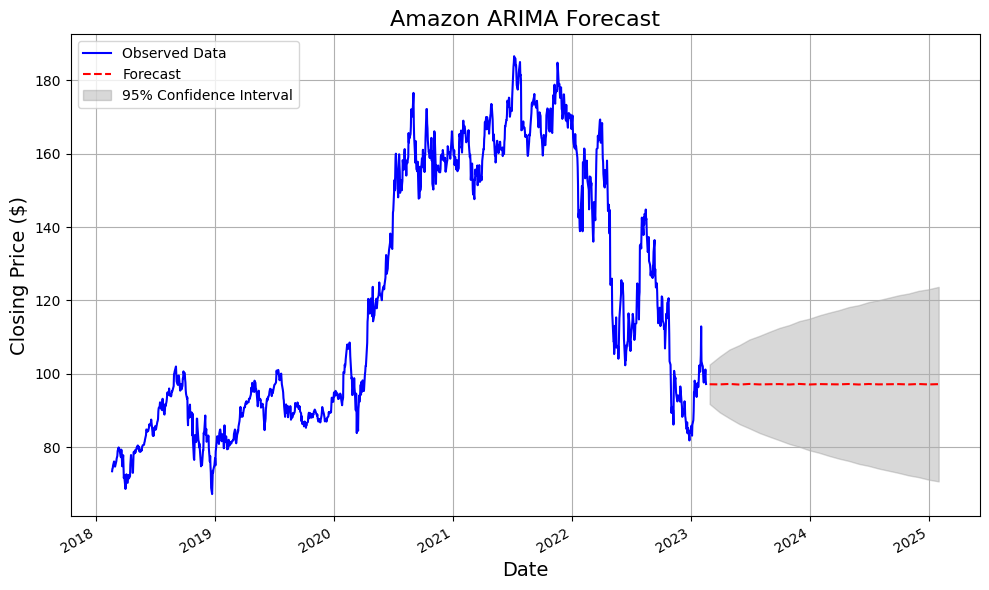

In [112]:
plot_amzn_arima_forecast(amzn_best_model_fit, amzn_df['Close'])


In [113]:
# Generate the 24-step forecast using get_forecast() method
n_forecast = 24
amzn_predictions_int = amzn_best_model_fit.get_forecast(steps=n_forecast)

# Extract predicted mean values for the forecast
amzn_predictions_int.predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
1259,97.138877
1260,97.100049
1261,97.224545
1262,97.050869
1263,97.225609
1264,97.096299
1265,97.147604
1266,97.184852
1267,97.072460
1268,97.227143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
<ipython-input-114-03469fc3fd11>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index_amzn = pd.date_range(start=amzn_df.index[-1] + pd.DateOffset(months=1),


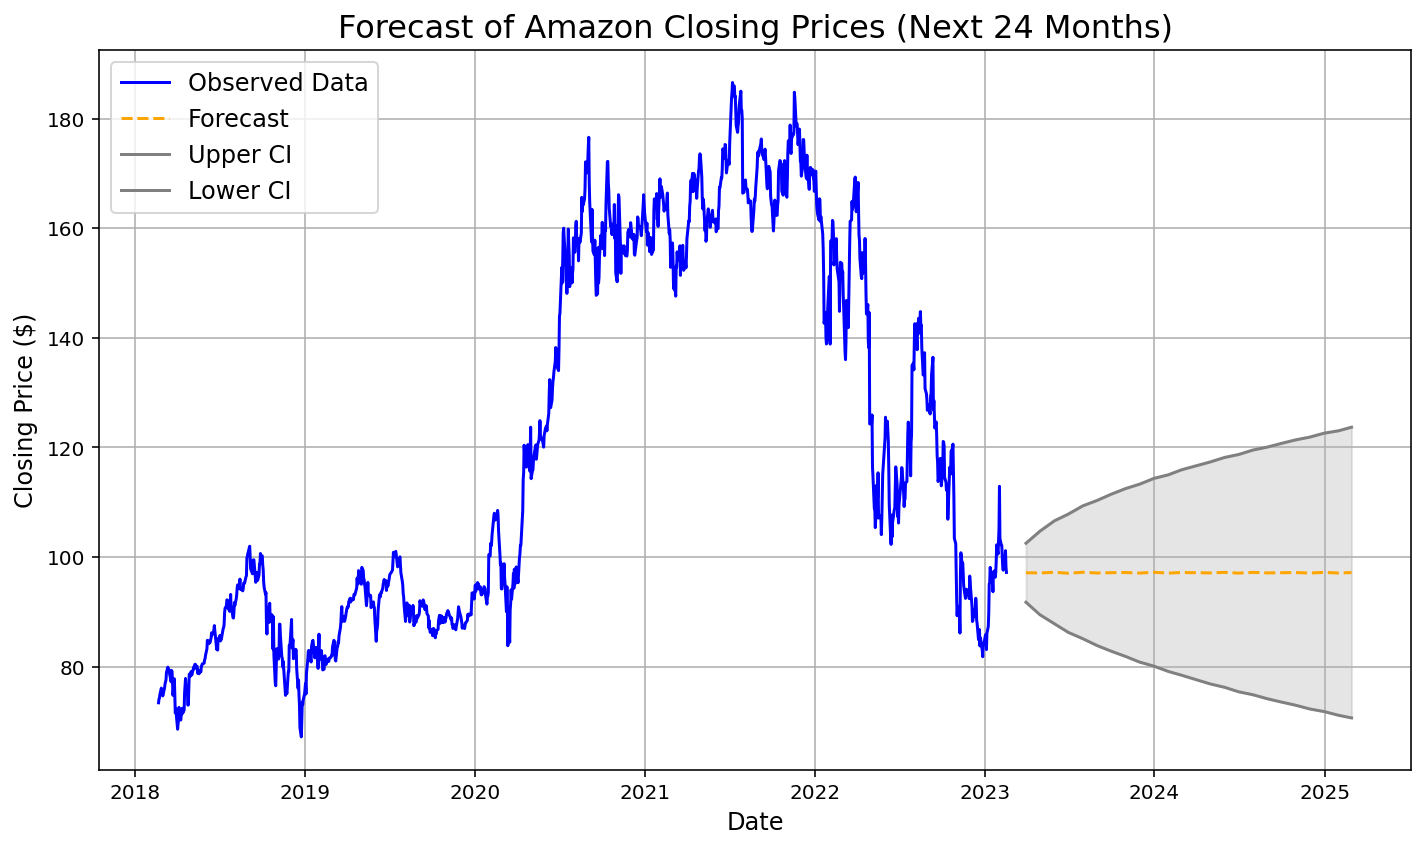

In [114]:
# Set forecast horizon
n_forecast = 24

# Generate forecast from Amazon ARIMA model
forecast_obj_amzn = amzn_best_model_fit.get_forecast(steps=n_forecast)
forecast_mean_amzn = forecast_obj_amzn.predicted_mean
forecast_ci_amzn = forecast_obj_amzn.conf_int()

# Create future date index starting one month after last observed value
forecast_index_amzn = pd.date_range(start=amzn_df.index[-1] + pd.DateOffset(months=1),
                                    periods=n_forecast, freq='M')

# Combine forecast and confidence intervals into a DataFrame
conf_df_amzn = pd.DataFrame({
    'Predictions': forecast_mean_amzn.values,
    'Lower CI': forecast_ci_amzn.iloc[:, 0].values,
    'Upper CI': forecast_ci_amzn.iloc[:, 1].values
}, index=forecast_index_amzn)

# Plot actual data and forecast
fig, ax = plt.subplots(figsize=(10, 6), dpi=144)

# Historical Amazon closing prices
ax.plot(amzn_df['Close'], color='blue', label='Observed Data')

# Forecast line and confidence interval
ax.plot(conf_df_amzn.index, conf_df_amzn['Predictions'], linestyle='--', color='orange', label='Forecast')
ax.fill_between(conf_df_amzn.index,
                conf_df_amzn['Lower CI'],
                conf_df_amzn['Upper CI'],
                color='grey', alpha=0.2)

# Update confidence interval labels
ax.plot(conf_df_amzn.index, conf_df_amzn['Upper CI'], color='grey', label='Upper CI')
ax.plot(conf_df_amzn.index, conf_df_amzn['Lower CI'], color='grey', label='Lower CI')

# Final plot formatting
ax.set_title('Forecast of Amazon Closing Prices (Next 24 Months)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Closing Price ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM NEURAL NETWORK
##Import Liaries

In [115]:
from math import sqrt
from numpy import concatenate
import pandas as pd
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np

In [155]:
# 1. Convert time series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    df = pd.DataFrame(data)
    n_vars = df.shape[1]
    cols, col_names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        col_names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(n_out):
        cols.append(df.shift(-i))
        label = '(t)' if i == 0 else f'(t+{i})'
        col_names += [f'var{j+1}{label}' for j in range(n_vars)]

    # Concatenate all columns
    supervised = pd.concat(cols, axis=1)
    supervised.columns = col_names

    # Drop rows with NaN values
    if dropnan:
        supervised.dropna(inplace=True)

    return supervised


In [156]:
# 2. Forecast accuracy metrics
def evaluate_forecast(y_true, y_pred):

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # RMSE
    rmse = sqrt(mean_squared_error(y_true, y_pred))

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE (avoid divide by zero)
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan  # Or: raise ValueError("y_true contains only zeros")

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [161]:
# 3. Train and Forecast with LSTM/GRU
# -----------------------------
def run_rnn_forecast(df, column='data', model_type='LSTM', n_input=12, n_forecast=24):
    series = df[[column]].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    reframed = series_to_supervised(scaled, n_in=n_input, n_out=1)
    values = reframed.values

    X, y = values[:, :-1], values[:, -1]
    X = X.reshape((X.shape[0], n_input, 1))

    # Split
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build model
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
    elif model_type == 'GRU':
        model.add(GRU(50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Predict on test
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred,)*1, axis=1))[:,0]
    y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1),)*1, axis=1))[:,0]

    # Forecast next 24 months
    future_input = X[-1].reshape(1, n_input, 1)
    forecast_scaled = []
    for _ in range(n_forecast):
        next_val = model.predict(future_input)[0,0]
        forecast_scaled.append(next_val)
        future_input = np.append(future_input[:, 1:, :], [[[next_val]]], axis=1)

    future_forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1)).flatten()

    # Forecast index
    last_date = df.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label='Original Data')
    plt.plot(forecast_index, future_forecast, label=f'{model_type} Forecast (24 months)', linestyle='--')
    plt.title(f'{model_type} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Actual vs Predicted for Test Set
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test_inv):], y_test_inv, label='Actual Test Data', color='blue')
    plt.plot(df.index[-len(y_pred_inv):], y_pred_inv, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'{model_type} Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate
    metrics = evaluate_forecast(y_test_inv, y_pred_inv)
    print(f' {model_type} Forecast Evaluation Metrics:')
    for k, v in metrics.items():
        print(f'{k}: {v:.4f}')

    return model, future_forecast, forecast_index, metrics


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-161-304bae92fa67>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')


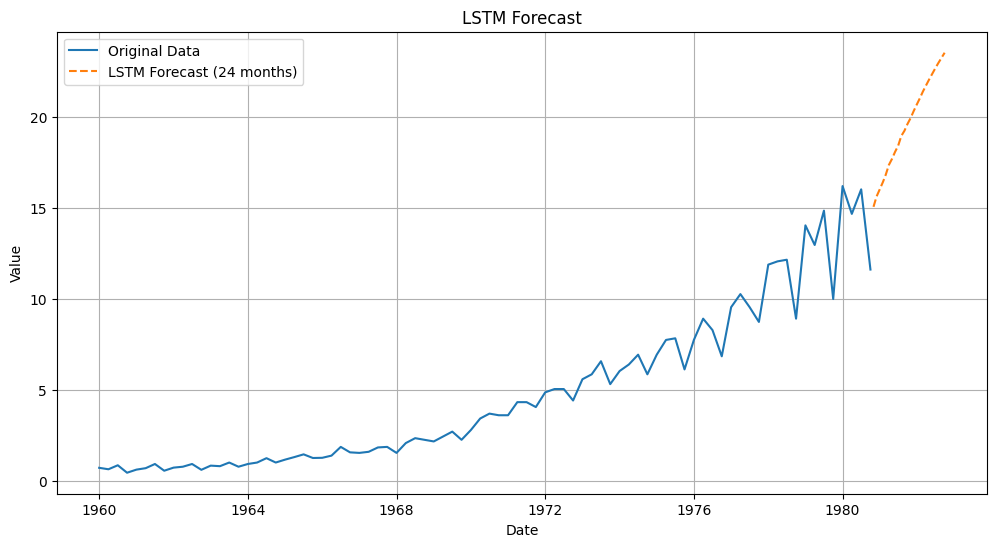

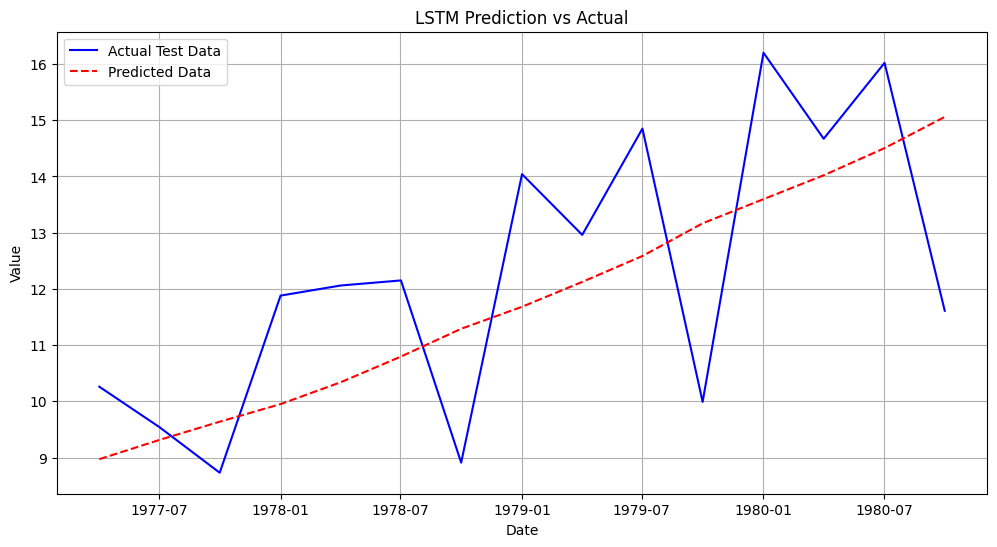

 LSTM Forecast Evaluation Metrics:
RMSE: 1.9932
MAE: 1.7775
MAPE: 14.9112


In [162]:
# For Johnson & Johnson
lstm_model, lstm_forecast, lstm_index, lstm_metrics = run_rnn_forecast(jj_df, column='data', model_type='LSTM')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-161-304bae92fa67>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')


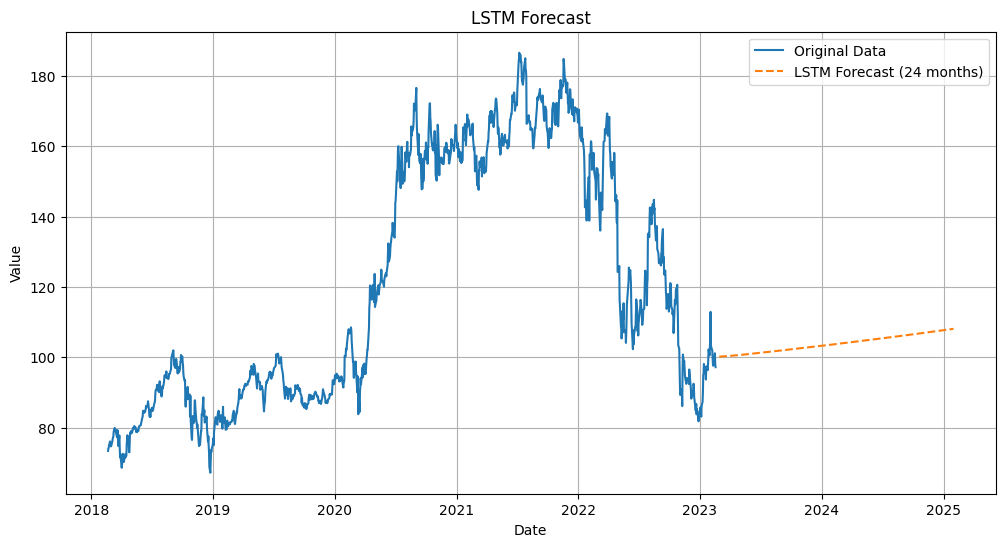

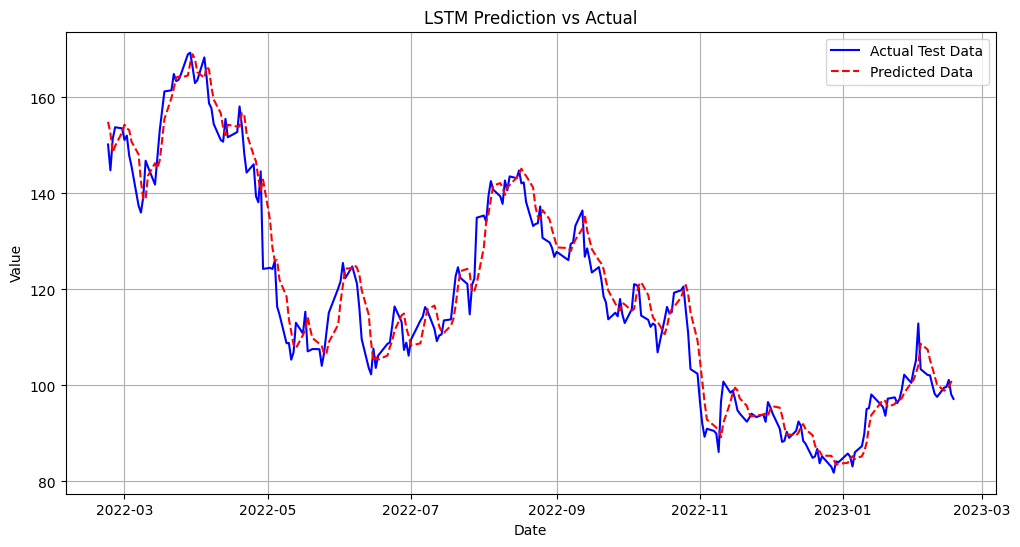

 LSTM Forecast Evaluation Metrics:
RMSE: 4.4961
MAE: 3.5511
MAPE: 3.0436


In [163]:
# For Amazon
lstm_model, lstm_forecast, lstm_index, lstm_metrics = run_rnn_forecast(amzn_df, column='Close', model_type='LSTM')